# Dimensionality Reduction methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df = pd.read_csv("../datasets/winequality.csv", sep=";")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


<AxesSubplot: >

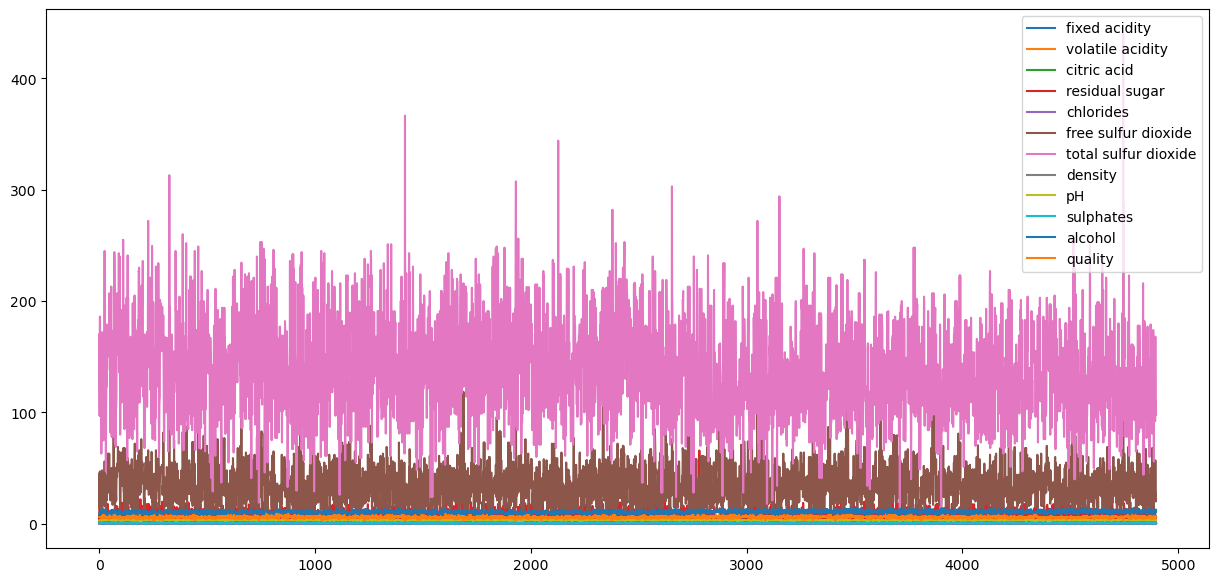

In [3]:
df.plot(figsize=(15, 7))

In [4]:
mean_quality = df.groupby('quality').mean()
mean_quality

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,7.600000,0.333250,0.336000,6.392500,0.054300,53.325000,170.600000,0.994884,3.187500,0.474500,10.345000
4,7.129448,0.381227,0.304233,4.628221,0.050098,23.358896,125.279141,0.994277,3.182883,0.476135,10.152454
5,6.933974,0.302011,0.337653,7.334969,0.051546,36.432052,150.904598,0.995263,3.168833,0.482203,9.808840
6,6.837671,0.260564,0.338025,6.441606,0.045217,35.650591,137.047316,0.993961,3.188599,0.491106,10.575372
7,6.734716,0.262767,0.325625,5.186477,0.038191,34.125568,125.114773,0.992452,3.213898,0.503102,11.367936
8,6.657143,0.277400,0.326514,5.671429,0.038314,36.720000,126.165714,0.992236,3.218686,0.486229,11.636000
9,7.420000,0.298000,0.386000,4.120000,0.027400,33.400000,116.000000,0.991460,3.308000,0.466000,12.180000


In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df["quality"], test_size=0.2, random_state=42, stratify=df["quality"])

x_train.shape, x_test.shape

((3918, 11), (980, 11))

In [6]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(learning_rate='adaptive', activation='relu', solver='adam', max_iter=500, hidden_layer_sizes=(20, 8, 8), random_state=42).fit(x_train, y_train)

In [7]:
# baseline accuracy score
mlp.score(x_test, y_test)

0.5418367346938775

## Sequential Forward selection

In [6]:
from sklearn.neural_network import MLPClassifier

# all input features
all_features = set(df.columns) - {"quality"}

feature_selection = []
prev_acc = 0

# iterate over the size of all features
for _ in all_features:
    max_acc = []
    # iterate over the features not yet included in the selection
    for x in all_features-set(feature_selection):
        # train MLP on current selection plus feature x and evaluate its score
        mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=(16, 8, 8), random_state=42).fit(x_train[feature_selection+[x]], y_train)
        acc = mlp.score(x_test[feature_selection+[x]], y_test)
        max_acc.append((acc, x))

    # sort so that first element is the feature that together with
    # selection produced the highest accuracy
    max_acc.sort(key=lambda t: t[0], reverse=True)
    # if the feature with the highest accuracy did not increase the previous accuracy, then quit
    if max_acc[0][0] < prev_acc: break
    # append feature with highest accuracy 
    feature_selection.append(max_acc[0][1])
    prev_acc = max_acc[0][0]
    print(max_acc)

print(feature_selection)

[(0.5214285714285715, 'alcohol'), (0.4663265306122449, 'total sulfur dioxide'), (0.45, 'free sulfur dioxide'), (0.4489795918367347, 'sulphates'), (0.4489795918367347, 'density'), (0.4489795918367347, 'chlorides'), (0.4489795918367347, 'pH'), (0.4448979591836735, 'citric acid'), (0.44081632653061226, 'residual sugar'), (0.44081632653061226, 'fixed acidity'), (0.43673469387755104, 'volatile acidity')]
[(0.5265306122448979, 'sulphates'), (0.5255102040816326, 'citric acid'), (0.5224489795918368, 'volatile acidity'), (0.5204081632653061, 'fixed acidity'), (0.5163265306122449, 'density'), (0.513265306122449, 'free sulfur dioxide'), (0.5091836734693878, 'chlorides'), (0.49795918367346936, 'pH'), (0.4959183673469388, 'total sulfur dioxide'), (0.49081632653061225, 'residual sugar')]
[(0.5295918367346939, 'citric acid'), (0.5285714285714286, 'density'), (0.5244897959183673, 'volatile acidity'), (0.523469387755102, 'chlorides'), (0.5204081632653061, 'free sulfur dioxide'), (0.5163265306122449, 'p

In [7]:
# feature set with only ['alcohol', 'sulphates', 'citric acid'] has a similar score than with all 11 features
mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=(16, 8, 8), random_state=42).fit(x_train[feature_selection], y_train)
mlp.score(x_test[feature_selection], y_test)

0.5295918367346939

## Sequential backward selection

In [8]:
from sklearn.neural_network import MLPClassifier

# all input features
all_features = set(df.columns) - {"quality"}

# start with every feature
feature_selection = [f for f in all_features]
prev_acc = 0

# iterate over the size of all features
for _ in all_features:
    max_acc = []
    # iterate over the selected features
    for x in feature_selection:
        # train MLP on current selection minus feature x and evaluate its score
        features = list(set(feature_selection)-{x})
        mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=(16, 8, 8), random_state=42).fit(x_train[features], y_train)
        acc = mlp.score(x_test[features], y_test)
        max_acc.append((acc, x))

    # sort so that first element is the feature that together with
    # selection produced the highest accuracy
    max_acc.sort(key=lambda t: t[0], reverse=True)
    # if the feature with the highest accuracy did not increase the previous accuracy, then quit
    if max_acc[0][0] < prev_acc: break 
    # append feature with highest accuracy 
    feature_selection.remove(max_acc[0][1])
    prev_acc = max_acc[0][0]
    print(max_acc)

print(feature_selection)

[(0.5295918367346939, 'total sulfur dioxide'), (0.5193877551020408, 'residual sugar'), (0.5061224489795918, 'sulphates'), (0.4489795918367347, 'density'), (0.4489795918367347, 'alcohol'), (0.4489795918367347, 'chlorides'), (0.4489795918367347, 'fixed acidity'), (0.4489795918367347, 'pH'), (0.4489795918367347, 'free sulfur dioxide'), (0.4479591836734694, 'volatile acidity'), (0.4479591836734694, 'citric acid')]
[(0.5469387755102041, 'density'), (0.5346938775510204, 'residual sugar'), (0.5336734693877551, 'chlorides'), (0.5326530612244897, 'sulphates'), (0.5316326530612245, 'pH'), (0.5295918367346939, 'citric acid'), (0.5265306122448979, 'fixed acidity'), (0.5255102040816326, 'volatile acidity'), (0.5081632653061224, 'free sulfur dioxide'), (0.4714285714285714, 'alcohol')]
[(0.5479591836734694, 'chlorides'), (0.5346938775510204, 'citric acid'), (0.5316326530612245, 'free sulfur dioxide'), (0.5285714285714286, 'fixed acidity'), (0.5265306122448979, 'sulphates'), (0.5214285714285715, 'pH')

In [9]:
mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=(16, 8, 8), random_state=42).fit(x_train[feature_selection], y_train)
mlp.score(x_test[feature_selection], y_test)

0.5479591836734694

## Principal Component Analysis

Example PCA on wine quality dataset

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(x_train)
x_train_pca = pca.transform(x_train)

pca_df = pd.concat([pd.DataFrame(x_train_pca, columns=['pc1', 'pc2']), y_train.reset_index(drop=True)], axis=1)
pca_df

,pc1,pc2,quality
0,11.488598,-1.582769,7
1,-30.282346,12.836652,7
2,40.941490,15.234333,5
3,-42.018865,7.733841,6
4,-36.715222,11.569311,8
...,...,...,...
3913,44.282519,4.067258,5
3914,23.088687,-8.825600,6
3915,-12.164777,-15.972143,5
3916,-22.578244,10.704343,7


Project $X$ onto $W$ so that after projection the variance is most spread out: 
$$
    X_{proj} = W^T(X-\overline{X})
$$ 
where $W$ is the $k$-dimensional matrix consisting of $k$ eigenvectors as columns.
The variances over these $k$ dimensions are the eigenvalues, which indicate how much variance is explained by the principal components (eigenvectors) of the new transformation.

[1927.17518703  172.72311284] [1927.17518703  172.72311284]
[0.91774692 0.08225308] [0.90753353 0.08133771]


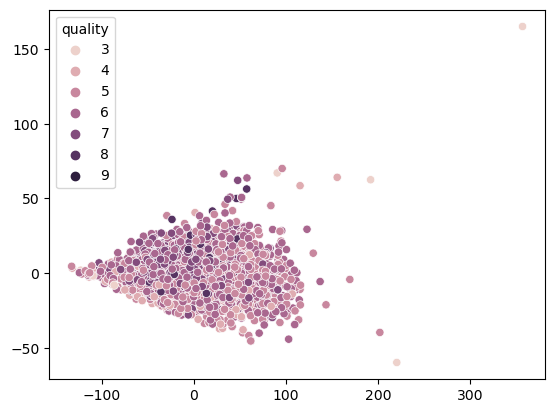

In [9]:
# X_proj = W @ (X - X_mean)
x_train_projected = pca.components_ @ (x_train - x_train.mean()).to_numpy().T

sns.scatterplot(x=x_train_projected[0, :], y=x_train_projected[1, :], hue=y_train)

assert np.all(x_train_projected.T == pca_df.iloc[:, :2].to_numpy()), "PCA eigenvecs matrix multiplied by (x_train - x_train.mean) must equal PCA output"

# The amount of variance explained is the variance of X_proj
explained_variance = x_train_projected.var(axis=1, ddof=1)

# why is there a difference between explained variance ratio and the one from PCA?
# [0.91862184 0.0823315 ] own computation 
# [0.90753353 0.08133771] from PCA
# --------------------------------- difference
# [0.01108831, 0.00099379]
explained_variance_ratio = explained_variance/(explained_variance.sum())

print(explained_variance, pca.explained_variance_) 
print(explained_variance_ratio, pca.explained_variance_ratio_)

array([0.90753353, 0.08133771])

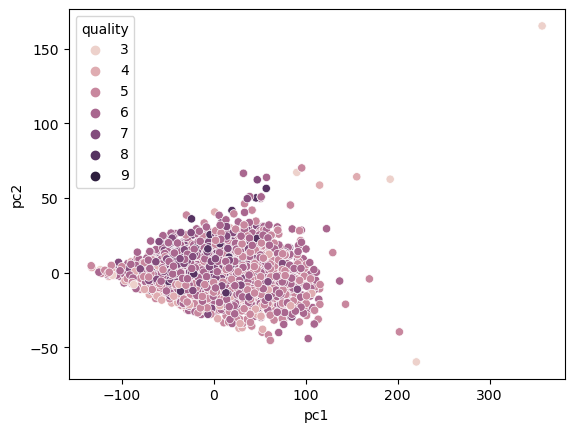

In [10]:
sns.scatterplot(pca_df, x='pc1', y='pc2', hue='quality')
pca.explained_variance_ratio_

Multivariate normal sample that has the shape of an ellipsoid projected and rotated to a new axis, i.e., projected onto new vectors

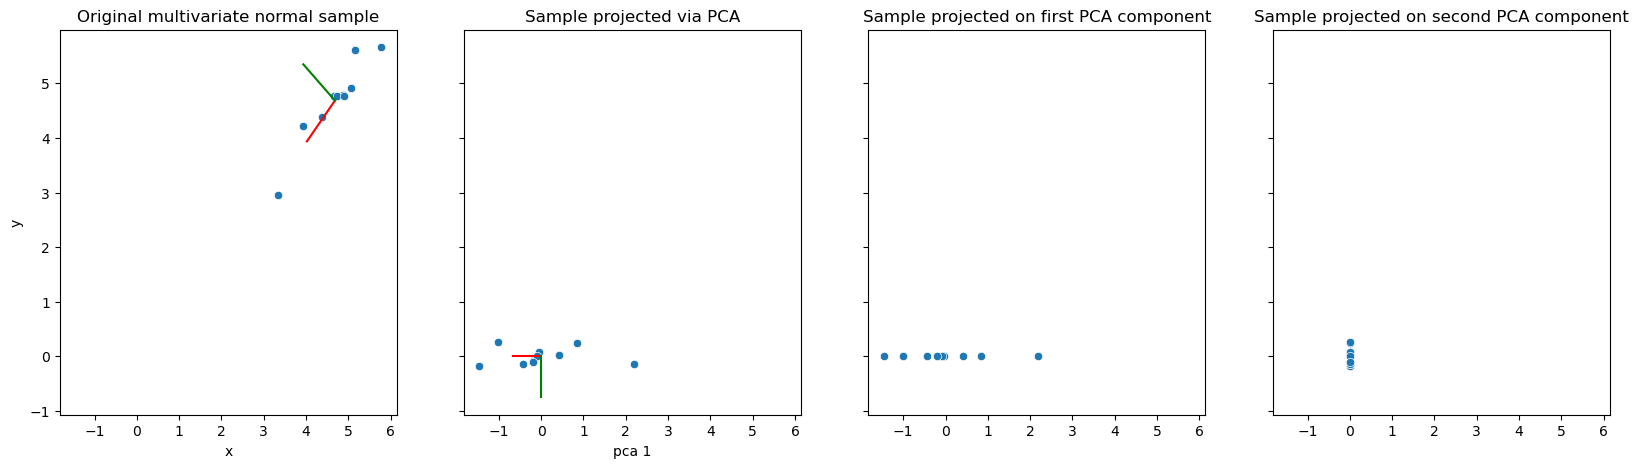

In [22]:
# Generate 2-dimensional sample of size N = 10
sample = np.random.multivariate_normal([5, 5], [[1, 0.95], [0.95, 1]], (10,))

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

# perform PCA
pca = PCA(n_components=2).fit(sample)
pca_sample = pca.transform(sample)

# plot sample together with projection vectors 
axes[0].set_title("Original multivariate normal sample")
sns.scatterplot(x=sample[:, 0], y=sample[:, 1], ax=axes[0])
mean = sample.mean()
v1x = pca.components_[0, 0] + mean
v1y = pca.components_[0, 1] + mean
v2x = pca.components_[1, 0] + mean
v2y = pca.components_[1, 1] + mean
axes[0].plot([mean, v1x], [mean, v1y], c='r')
axes[0].plot([mean, v2x], [mean, v2y], c='g')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# plot PCA components 
axes[1].set_title("Sample projected via PCA")
sns.scatterplot(x=pca_sample[:, 0], y=pca_sample[:, 1], ax=axes[1])
axes[1].plot([0, pca.components_[0, 0]], [0, 0], c='r')
axes[1].plot([0, 0], [0, pca.components_[1, 0]], c='g')
axes[1].set_xlabel('pca 1')
axes[1].set_ylabel('pca 2')

# plot only the first PCA component
axes[2].set_title("Sample projected on first PCA component")
sns.scatterplot(x=pca_sample[:, 0], y=np.zeros_like(pca_sample[:, 0]), ax=axes[2])

# plot only the second PCA component
axes[3].set_title("Sample projected on second PCA component")
sns.scatterplot(x=np.zeros_like(pca_sample[:, 0]), y=pca_sample[:, 1], ax=axes[3])

plt.show()

2.709042122478456 2.709042122478456
0.9959409917986732 [0.99594099]
1.2612929142047649 1.2612929142047649
0.9858741660614911 [0.98587417]
2.5299970468016912 2.529997046801691
0.9770109421996065 [0.97701094]
1.8792470535820958 1.8792470535820953
0.9805717074019064 [0.98057171]


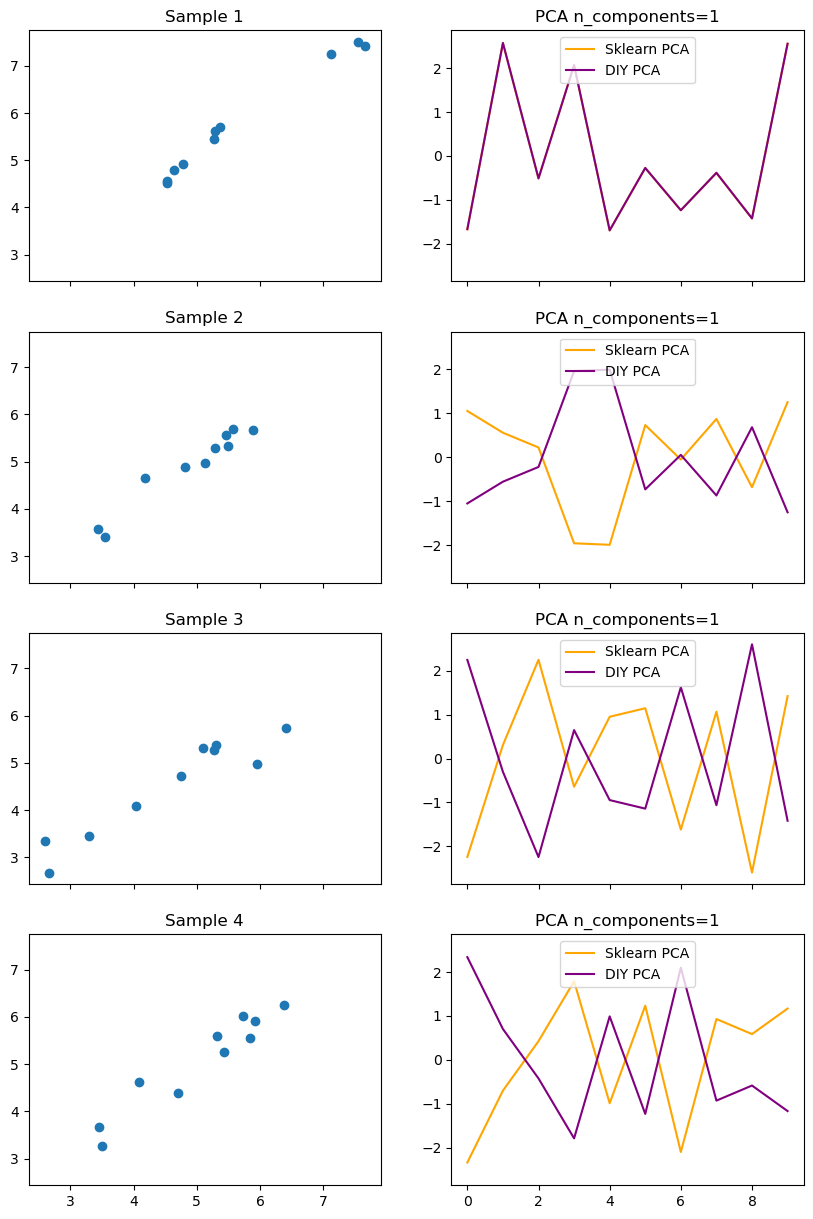

In [23]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15), sharex='col', sharey='col')

for i in range(len(axes)):
    # sample drawn from the multivariate normal (skewed in one dimension)
    sample = np.random.multivariate_normal([5, 5], [[1, 0.95], [0.95, 1]], (10,)).T

    # compute covariance matrix of sample
    sigma = np.cov(sample, ddof=1)

    # compute eigenvals and eigenvecs of sigma
    eigvals, eigvecs = np.linalg.eig(sigma)

    # get index of maximal eigenvalue
    max_eigval_index = eigvals.argmax()

    # use index to get the cooresponding eigenvector
    # this is the first principal component
    pc1 = eigvecs[:, max_eigval_index].reshape(-1, 1)

    # PCA projection formula: X_proj = W^T @ (X - X_mean)
    x_proj = pc1.T @ (sample - sample.mean())

    # check how sklearn PCA differs
    pca = PCA(n_components=1).fit(sample.T)
    pca_sample = pca.transform(sample.T)
    
    axes[i][0].set_title(f"Sample {i+1}")
    axes[i][1].set_title(f"PCA n_components=1")
    
    axes[i][0].scatter(sample[0, :], sample[1, :])
    axes[i][1].plot(x_proj.T, label="Sklearn PCA", c="orange")
    axes[i][1].plot(pca_sample, label="DIY PCA", c="purple")
    axes[i][1].legend(loc=9)

    print(x_proj.var(), pca_sample.var())
    explained_variance = eigvals / eigvals.sum()
    print(explained_variance.max(), pca.explained_variance_ratio_)

Spectral decomposition $\mathbf{X}\mathbf{X}^T$:
$$
    \mathbf{X}\mathbf{X}^T = \mathbf{V}\mathbf{E}\mathbf{V}^T
$$
where $\mathbf{V}$ is the $N\times N$ matrix containing the eigenvectors of $\mathbf{X}\mathbf{X}^T$ in its columns, and $\mathbf{E}$ is the $N\times N$ diagonal matrix with the corresponding eigenvalues.

In [30]:
sample = np.random.multivariate_normal([5, 5], [[1, 0.95], [0.95, 1]], (10,))

XXt = sample @ sample.T

eigvals, eigvecs = np.linalg.eigh(XXt)

V = eigvecs
E = np.diag(eigvals)

decomp = V @ E @ V.T

decomp[:3, :3], XXt[:3, :3]

(array([[39.57021786, 31.792618  , 48.26758068],
        [31.792618  , 25.5547676 , 38.78406284],
        [48.26758068, 38.78406284, 58.87773655]]),
 array([[39.57021786, 31.792618  , 48.26758068],
        [31.792618  , 25.5547676 , 38.78406284],
        [48.26758068, 38.78406284, 58.87773655]]))

Spectral decomposition $\mathbf{X}^T\mathbf{X}$:
$$
    \mathbf{X}^T\mathbf{X} = \mathbf{W}\mathbf{D}\mathbf{W}^T
$$
where $\mathbf{W}$ is the $d\times d$ matrix containing the eigenvectors of $\mathbf{X}^T\mathbf{X}$ in its columns, and $\mathbf{D}$ is the $d\times d$ diagonal matrix with the corresponding eigenvalues.

In [31]:
sample = np.random.multivariate_normal([5, 5], [[1, 0.95], [0.95, 1]], (10,))

XtX = sample.T @ sample

eigvals, eigvecs = np.linalg.eigh(XtX)

W = eigvecs
D = np.diag(eigvals)

decomp = W @ D @ W.T

decomp, XtX

(array([[236.56743913, 237.4233969 ],
        [237.4233969 , 238.65698378]]),
 array([[236.56743913, 237.4233969 ],
        [237.4233969 , 238.65698378]]))

Example of PCA projection

(array([[1.28617867, 0.55189068],
        [2.09495176, 1.06840216],
        [1.86814023, 0.92355219],
        [2.45010179, 1.2952137 ]]),
 1,
 0.3691267289868627,
 2.5,
 1.327080484691459)

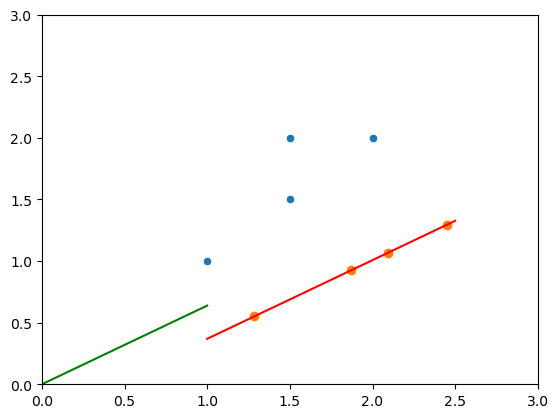

In [251]:
people = np.array([
    [2, 2],
    [2.5, 3],
    [2.5, 2.5],
    [3, 3],
])-1

plt.xlim(0, 3)
plt.ylim(0, 3)
sns.scatterplot(x=people[:, 0], y=people[:, 1])

pca = PCA(n_components=1).fit(people)

x1 = 1
x2 = 2.5
y1 = -pca.components_[0, 0] * x1 + pca.components_[0, 1] + 0.5
y2 = -pca.components_[0, 0] * x2 + pca.components_[0, 1] + 0.5

plt.plot([x1, x2], [y1, y2], c='r')

v = np.array([1., -pca.components_[0, 0]])

plt.plot([0, v[0]], [0, v[1]], c='g')

A = np.array([x1, y1])
B = np.array([x2, y2])

proj = np.array([B + (np.dot((C-B), v)/np.dot(v, v)) * v for C in people])

plt.scatter(proj[:, 0], proj[:, 1])
proj, x1, y1, x2, y2

Variance measures the spread of data along one dimension via the formula:
$$
    var(X) = \frac{\sum_i (x_i - \overline{x})^2}{N}
$$
However, variance cannot tell d-dimensional data apart, for a measure of variance between 2 variables, we need the covariance measure, defined by the formula:
$$
    cov(X, Y) = \frac{\sum_i (x_i-\overline{x}) (y_i-\overline{y}) }{N-1}
$$
To find the variances of every pair of variables, the covariance matrix can be constructed, where the diagonal $c_{ii}$ indicates the variance of the variable $D_i$ and $D_i$, and the entries $c_{ij}$ indicate the covariance of variable $D_i$ and $D_j$. 

In [151]:
data = np.array([
    [-2, 1],
    [0, 0],
    [2, -1]
])

cov_xy = lambda X, Y: np.sum((X - X.mean()) * (Y - Y.mean()), axis=0)/(X.shape[0]-1)

n_variables = data.shape[1]
cov_mat = [
    [
        cov_xy(data[:, i], data[:, j]) 
        for i in range(n_variables)
    ]
    for j in range(n_variables)
]

np.array(cov_mat), np.cov(data, rowvar=False)

(array([[ 4., -2.],
        [-2.,  1.]]),
 array([[ 4., -2.],
        [-2.,  1.]]))

If Cov(data) is diagonal, meaning its main diagonal is occupied with nonzero values, and all other values are zero, then every variable is uncorrelated with each other. 
$$
    \text{Cov}(data) = \begin{bmatrix}
        v_1 & 0 & \ldots & 0\\
        0 & v_2 & \ldots & 0\\
        \vdots & \vdots & \ddots & \vdots\\
        0 & 0 & \ldots & v_k\\
    \end{bmatrix}
$$ 
The projected data matrix should have a covariance with this exact property, because the new dimensions should have no correlation with each other. 

Another way to compute the covariance matrix is to first center $X$ to have mean 0, and then compute $X^T X$, which is is the same as element wise computing every dot product for the instances $i$ and $j$, that is $(x^i)^T (x^j)$ where $i, j = 1, \dots, N$.  

In [53]:
X = np.array([
    [2, 2],
    [2.5, 3],
    [2.5, 2.5],
    [3, 3],
])

cov_X = np.cov(X, rowvar=False, ddof=0)

X = X - X.mean(axis=0)

cov_X_DIY = (X.T @ X)/4

cov_X_DIY, cov_X

(array([[0.125   , 0.125   ],
        [0.125   , 0.171875]]),
 array([[0.125   , 0.125   ],
        [0.125   , 0.171875]]))

In [52]:
cov_X_DIY/cov_X_DIY.sum(), cov_X/cov_X.sum(), 

(array([[0.22857143, 0.22857143],
        [0.22857143, 0.31428571]]),
 array([[0.22857143, 0.22857143],
        [0.22857143, 0.31428571]]))

## Linear Discriminant Analysis

Example 1

<AxesSubplot: >

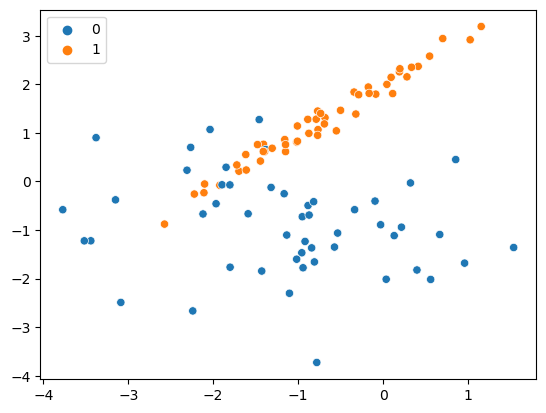

In [126]:
from sklearn.datasets import make_classification

X, y = make_classification(random_state=4, n_samples=100, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=2)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

Text(0.5, 1.0, 'LDA class distributions')

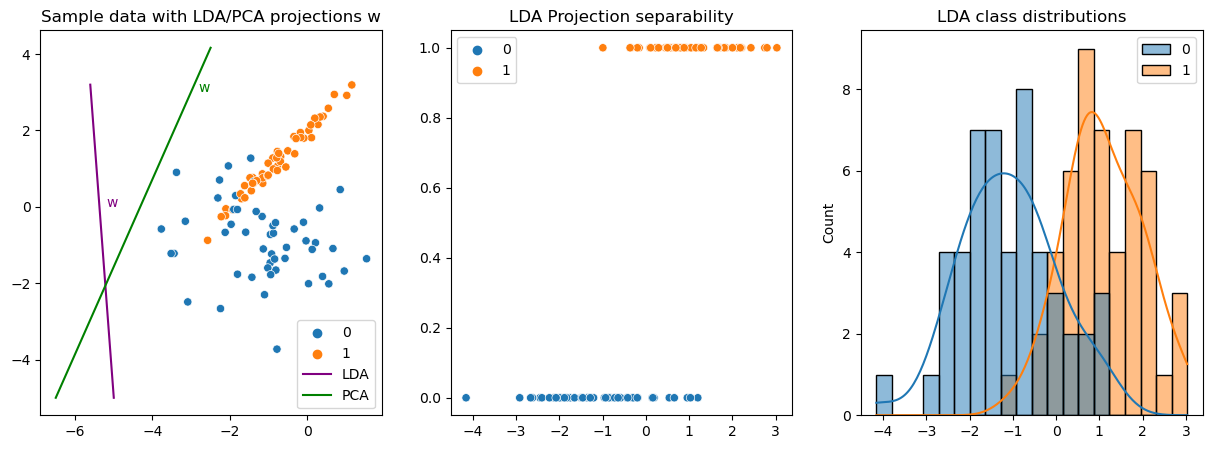

In [165]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

lda = LinearDiscriminantAnalysis(n_components=1).fit(X, y)
lda_X = lda.transform(X)

pca = PCA(n_components=1).fit(X)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=axes[0])
coeff = np.array([[0, 0], lda.coef_.ravel()]) * 3.5 + np.array([[-5], [-5]])
axes[0].plot(coeff[:, 0], coeff[:, 1], c="purple", label="LDA")
axes[0].text(-5.2, 0, "w", c="purple")
coeff = np.array([[0, 0], pca.components_.ravel()]) * 10 + np.array([[-6.5, -5], [-6.5, -5]])
axes[0].plot(coeff[:, 0], coeff[:, 1], c="green", label="PCA")
axes[0].text(-2.8, 3, "w", c="green")
axes[0].legend()
axes[0].set_title("Sample data with LDA/PCA projections w")

sns.scatterplot(x=lda_X[:, 0], y=y, hue=y, ax=axes[1])
axes[1].set_title("LDA Projection separability")

sns.histplot(x=lda_X[:, 0], hue=y, bins=20, kde=True, ax=axes[2])
axes[2].set_title("LDA class distributions")

Example 2

<AxesSubplot: >

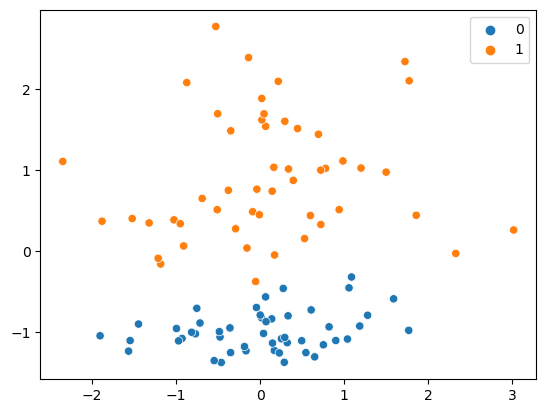

In [166]:
X, y = make_classification(
    random_state=121, 
    n_samples=100, 
    n_features=2, 
    n_redundant=0, 
    n_informative=1, 
    n_clusters_per_class=1, 
    n_classes=2
)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

Text(0.5, 1.0, 'LDA class distributions')

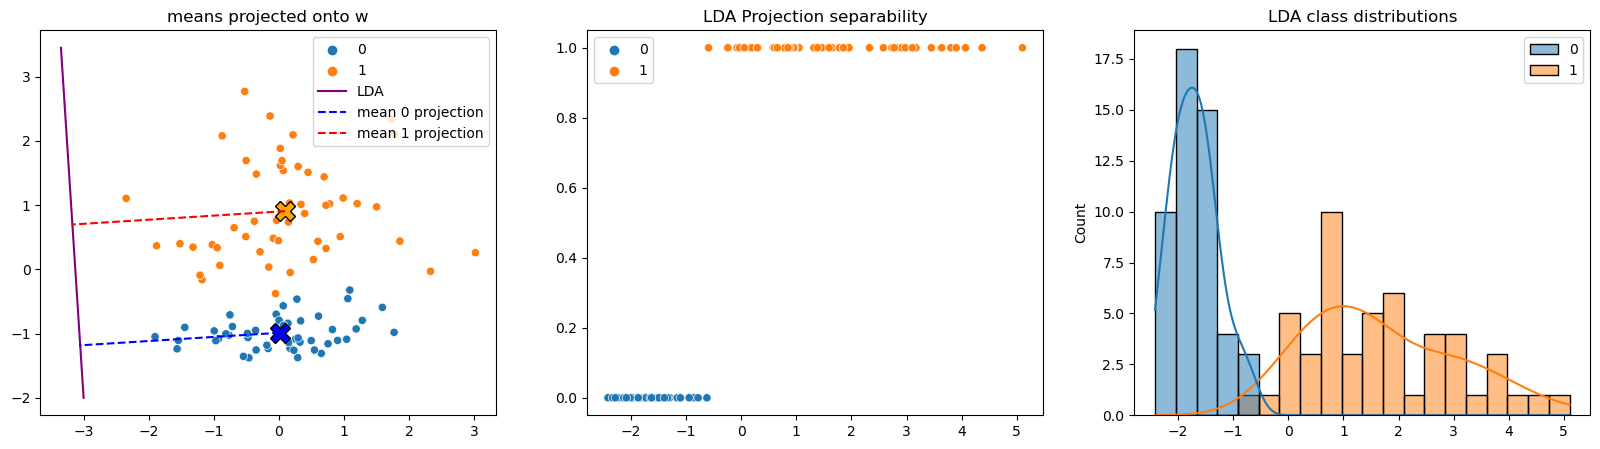

In [218]:
lda = LinearDiscriminantAnalysis(n_components=1).fit(X, y)
lda_X = lda.transform(X)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=axes[0])

axes[0].plot(lda.means_[0, 0], lda.means_[0, 1], 'X', c='blue', markersize=15, mec='black')
axes[0].plot(lda.means_[1, 0], lda.means_[1, 1], 'X', c='orange', markersize=15, mec='black')
coeff = np.array([[0, 0], lda.coef_.ravel()]) * 0.9 + np.array([[-3, -2], [-3, -2]])
axes[0].plot(coeff[:, 0], coeff[:, 1], c="purple", label="LDA")

p1 = lda.means_[0] - lda.coef_ * np.dot(lda.coef_.ravel(), lda.means_[0])/np.dot(lda.coef_.ravel(), lda.coef_.ravel())
p1 = p1 * 60
axes[0].plot([lda.means_[0, 0], p1[0, 0]+ lda.means_[0, 0]], [lda.means_[0, 1], p1[0, 1]+ lda.means_[0, 1]], c="b", label="mean 0 projection", linestyle = 'dashed')

p2 = lda.means_[1] - lda.coef_ * np.dot(lda.coef_.ravel(), lda.means_[1])/np.dot(lda.coef_.ravel(), lda.coef_.ravel())
p2 = p2 * -21.6
axes[0].plot([lda.means_[1, 0], p2[0, 0] + lda.means_[1, 0]], [lda.means_[1, 1], p2[0, 1]+ lda.means_[1, 1]], c="red", label="mean 1 projection", linestyle = 'dashed')
axes[0].set_title("means projected onto w")
axes[0].legend()

sns.scatterplot(x=lda_X[:, 0], y=y, hue=y, ax=axes[1])
axes[1].set_title("LDA Projection separability")

sns.histplot(x=lda_X[:, 0], hue=y, bins=20, kde=True, ax=axes[2])
axes[2].set_title("LDA class distributions")

In the following, a data set $\mathbf{X}$ is constructed of 4 two-dimensional datapoints with labels $\mathbf{y}$ consisting of two classes. Furthermore, an arbitrary projection vector $\mathbf{w}$ is used.

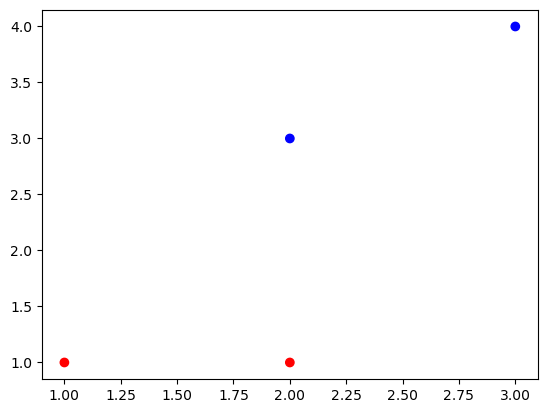

In [84]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'blue'])

X = np.array([
    [1, 1],
    [2, 3],
    [3, 4],
    [2, 1]
])
y = np.array([0, 1, 1, 0])

w = np.array([1, 2])

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

\begin{align*}
    m_1 &= \frac{\sum_t \mathbf{w}^T \mathbf{x}^t r^t}{\sum_t r^t} = \mathbf{w}^T \mathbf{m}_1\\
    m_2 &= \frac{\sum_t \mathbf{w}^T \mathbf{x}^t (1-r^t)}{\sum_t (1-r^t)} = \mathbf{w}^T \mathbf{m}_2
\end{align*}

In [85]:
# class 1: r = 1
m1_sum_num = np.sum([w @ xt * r for xt, r in zip(X, y)])
m1_sum_denom = np.where(y == 1, 1, 0).sum()
m1 = m1_sum_num / m1_sum_denom

m1_fast = w @ X[y == 1].mean(axis=0)
print(f"{m1=}, {m1_fast=}")

# class 2: r = 0
m2_sum_num = np.sum([w @ xt * (1-r) for xt, r in zip(X, y)])
m2_sum_denom = np.where(y == 0, 1, 0).sum()
m2 = m2_sum_num / m2_sum_denom

m2_fast = w @ X[y == 0].mean(axis=0)
print(f"{m2=}, {m2_fast=}")

m1=9.5, m1_fast=9.5
m2=3.5, m2_fast=3.5


\begin{align*}
    s_1^2 &= \sum_t (\mathbf{w}^T \mathbf{x}^t - m_1)^2 r^t\\
    s_2^2 &= \sum_t (\mathbf{w}^T \mathbf{x}^t - m_2)^2 (1-r^t)
\end{align*}

In [86]:
m1 = w @ X[y == 1].mean(axis=0)
s1 = np.sum([(w @ xt - m1)**2 * r for xt, r in zip(X, y)])
# s1/np.where(y == 1, 1, 0).sum() == (w @ X[y == 1]).var()

m2 = w @ X[y == 0].mean(axis=0)
s2 = np.sum([(w @ xt - m2)**2 * (1-r) for xt, r in zip(X, y)])

s1, s2

(4.5, 0.5)

\begin{align*}
    \mathbf{S}_1 &= \sum_t r^t (\mathbf{x}^t - \mathbf{m}_1)(\mathbf{x}^t - \mathbf{m}_1)^T\\
    \mathbf{S}_2 &= \sum_t (1-r^t) (\mathbf{x}^t - \mathbf{m}_2)(\mathbf{x}^t - \mathbf{m}_2)^T
\end{align*}

In [100]:
M1 = X[y == 1].mean(axis=0)
M2 = X[y == 0].mean(axis=0)
M1, M2

(array([2.5, 3.5]), array([1.5, 1. ]))

In [87]:
M1 = X[y == 1].mean(axis=0)
S1 = np.sum([
    r * (xt - M1)[..., None] @ (xt - M1)[..., None, :] 
    for xt, r in zip(X, y)
], axis=0)

print(f"S1:\n{S1}")
print(f"w^T @ S1 @ w = {w[..., None, :] @ S1 @ w[..., None]}")
print()
M2 = X[y == 0].mean(axis=0)
S2 = np.sum([
    (1-r) * (xt - M2)[..., None] @ (xt - M2)[..., None, :] 
    for xt, r in zip(X, y)
], axis=0)

print(f"S2:\n{S2}")
print(f"w^T @ S2 @ w = {w[..., None, :] @ S2 @ w[..., None]}")


S1:
[[0.5 0.5]
 [0.5 0.5]]
w^T @ S1 @ w = [[4.5]]

S2:
[[0.5 0. ]
 [0.  0. ]]
w^T @ S2 @ w = [[0.5]]


$$
    s_1^2 + s_2^2 = \mathbf{w}^T \mathbf{S}_W \mathbf{w}
$$
where $\mathbf{S}_W = \mathbf{S}_1 + \mathbf{S}_2$ is the total within-class scatter matrix. 

$$
    \mathbf{w} = c \mathbf{S}_W^{-1}(\mathbf{m}_1 - \mathbf{m}_2)
$$

In [88]:
SW = S1 + S2
w_p = np.linalg.pinv(SW) @ (M1 - M2)
w_p

# np.linalg.pinv(S1+S2) @ (M1-M2)

array([-3.,  8.])

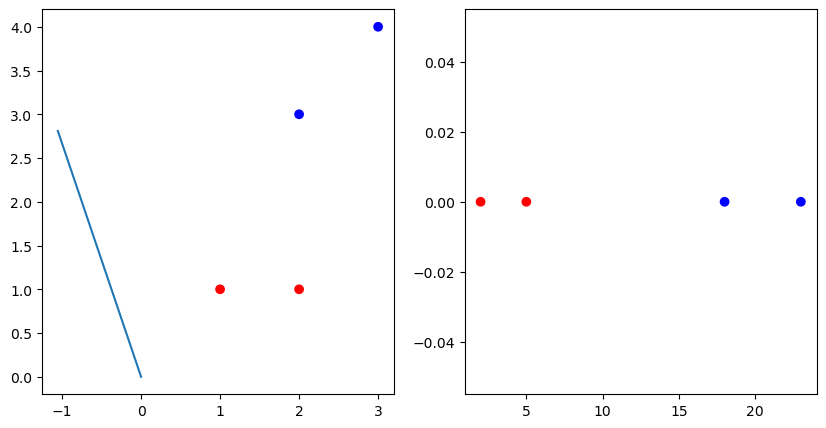

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

w_p_norm = w_p/np.linalg.norm(w_p) * 3

axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
axes[0].plot([0, w_p_norm[0]], [0, w_p_norm[1]])

X_proj = w_p @ X.T
axes[1].scatter(X_proj, np.zeros_like(X_proj), c=y, cmap=cmap)

Note that `Sklearn LDA` does the same 

In [99]:
lda = LinearDiscriminantAnalysis().fit(X, y)
# not concerned with magnitude (length) of w_p
print(lda.coef_.ravel(), w_p*2)

[-6. 16.] [-6. 16.]
